In [18]:
from sklearn.datasets import fetch_20newsgroups
import pandas as pd
import openai
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import re
import string
from collections import defaultdict
import itertools
from typing import List
from tqdm import tqdm
import os.path
from adjustText import adjust_text
import data
import pickle as pkl

**Load and prepare data**

In [11]:
df = data.get_metadata()

**Compute author stats**

In [7]:
def get_authors_list(s: str) -> List:
    return [
        a.lower().strip()
        for a in re.split('and |, |\n', s)
    ]

authors_list_arr = df.authors.apply(get_authors_list)
author_dict = defaultdict(list)
for i, l in enumerate(authors_list_arr):
    for author in l:
        author_dict[author].append(i)

In [8]:
# prune the authors list
authors_list = sorted(set(list(itertools.chain.from_iterable(authors_list_arr))))
def contains_num(x):
    if True in [char.isdigit() for char in x]:
        return True
    return False
keywords = re.compile(r'universi|departm|faculty|institute|global|center|laboratory')
authors_list = [
    a for a in authors_list
    if keywords.search(a) is None
    and not any(p in a for p in string.punctuation)
    and not contains_num(a)
    and len(a) > 3
    and len(a.split()) > 1
    and len(a.split()[0]) > 1
]
author_dict_clean = {
    a: author_dict[a]
    for a in authors_list
}
assert len(authors_list) == len(author_dict_clean)

**Paper counts plot**

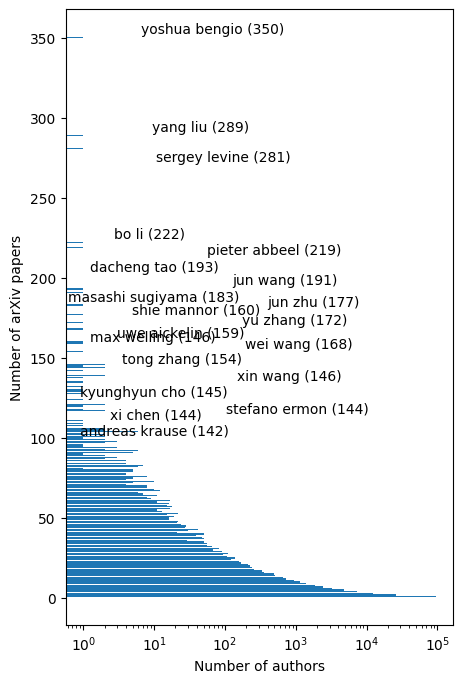

In [9]:
plt.figure(figsize=(5, 8))
plt.xscale('log')
paper_idxs = author_dict_clean.values()
paper_counts = np.array([len(x) for x in paper_idxs])
count, count_freq = np.unique(paper_counts, return_counts=True)
# plt.bar(x=count, height=count_freq)
plt.barh(y=count, width=count_freq)
plt.xlabel('Number of authors')
plt.ylabel('Number of arXiv papers')


# get top20 authors
ind = np.argpartition(paper_counts, -20)[-20:]
ind = ind[np.argsort(paper_counts[ind])][::-1]
texts = []
for offset, i in enumerate(ind):
    # print(authors_list[i], paper_counts[i])
    texts.append(plt.text(y=paper_counts[i], x=10, s=authors_list[i] + f' ({paper_counts[i]})'))
adjust_text(texts, autoalign='y')
plt.savefig('figs/author_counts.svg', bbox_inches='tight')
plt.show()

In [15]:
titles = df['title'].values
authors_dict_titles = {
    author: titles[author_dict_clean[author]]
    for author in tqdm(author_dict_clean.keys())
}

100%|██████████| 161814/161814 [00:00<00:00, 427669.33it/s]


In [24]:
# sort by num papers and save
authors = np.array(list(authors_dict_titles.keys()))
args = np.argsort(paper_counts)[::-1]
authors_dict_titles = {
    a: authors_dict_titles[a]
    for a in authors[args]
}

In [27]:
pkl.dump(authors_dict_titles, open('../data/authors_dict_titles.pkl', 'wb'))